<a href="https://colab.research.google.com/github/samyogbhatta/group6_MLPC-grpAssignment/blob/main/grp6GA(MLPC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pygad
!pip install torch

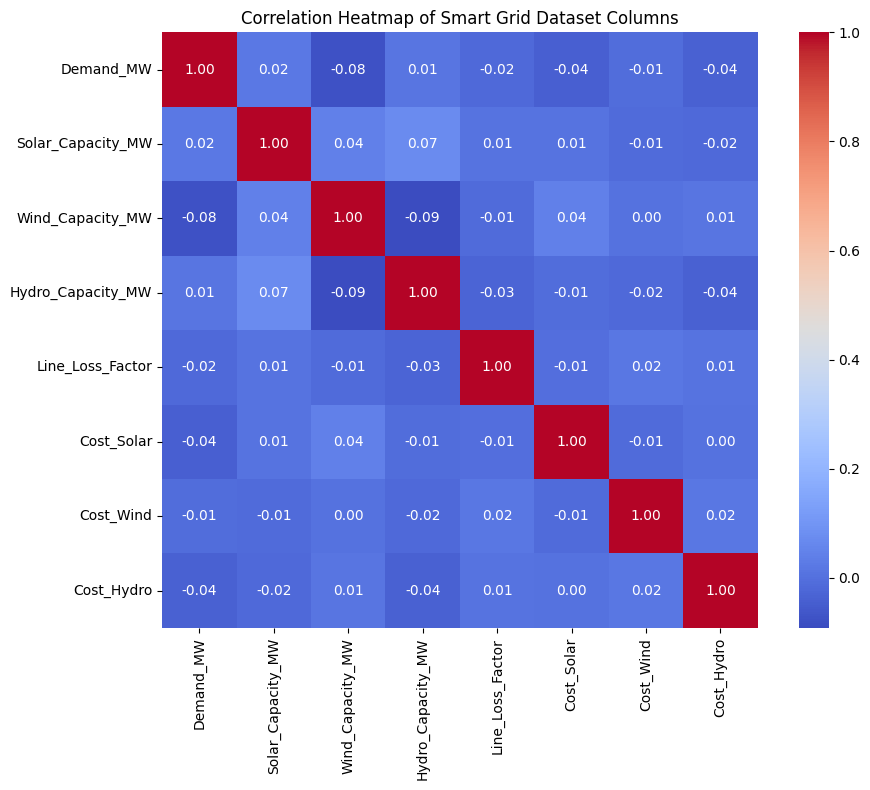


Summary Comparison Table:
        Method  Execution Time (s)  Total Cost / -Fitness
0       Greedy            0.002120           7.167173e+06
1  GA Parallel          171.744462           1.063495e+08
2    GA Serial           15.226884           1.060548e+08


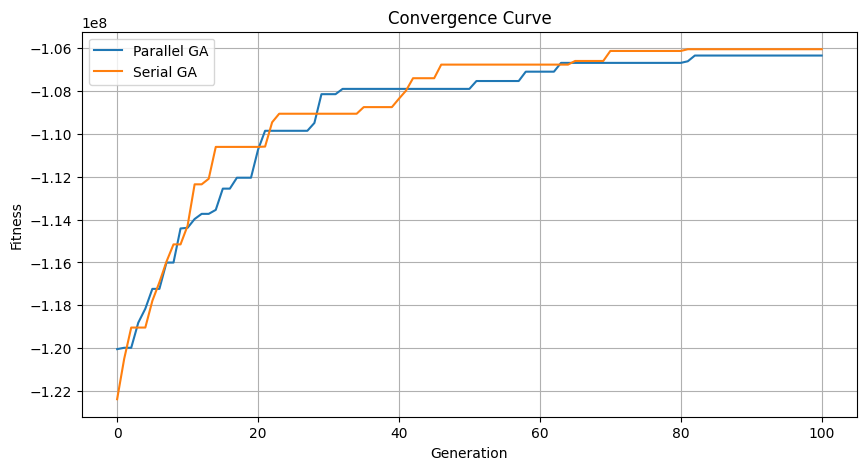

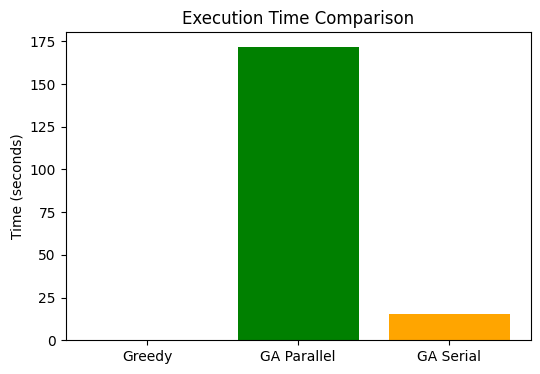

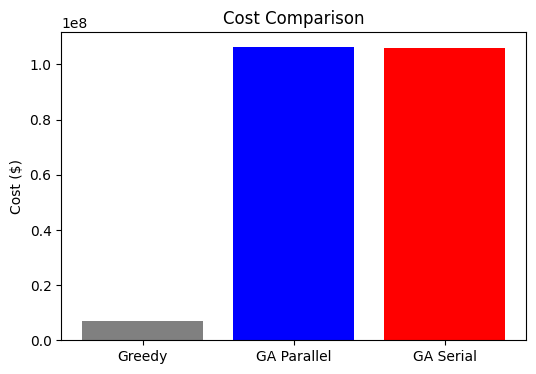

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import pygad
import torch
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# 1. Generate a Realistic Smart Grid Dataset
def generate_smart_grid_dataset(nodes=30, sources=3, hours=24):
    """
    Simulates energy demand and supply capacities for multiple nodes over a day.
    Each row contains hour, node, demand, capacities from solar/wind/hydro,
    loss factor, and cost of each energy type.
    """
    data = {
        'Hour': np.repeat(range(hours), nodes),
        'Node': np.tile(range(nodes), hours),
        'Demand_MW': np.random.uniform(50, 200, nodes * hours),
        'Solar_Capacity_MW': np.random.uniform(0, 100, nodes * hours),
        'Wind_Capacity_MW': np.random.uniform(0, 150, nodes * hours),
        'Hydro_Capacity_MW': np.random.uniform(0, 120, nodes * hours),
        'Line_Loss_Factor': np.random.uniform(0.05, 0.15, nodes * hours),
        'Cost_Solar': np.random.uniform(0.08, 0.12, nodes * hours),
        'Cost_Wind': np.random.uniform(0.06, 0.10, nodes * hours),
        'Cost_Hydro': np.random.uniform(0.04, 0.08, nodes * hours),
    }
    return pd.DataFrame(data)

# Generate dataset
dataset = generate_smart_grid_dataset()

# 2. Smart Grid Optimization Problem Definition
class SmartGridOptimizer:
    """
    Class encapsulating the smart grid optimization logic.
    Contains cost matrices, demand, loss factor, and capacities.
    Also includes fitness function and greedy baseline.
    """
    def __init__(self, dataset, nodes=30, sources=3, hours=24):
        self.dataset = dataset
        self.nodes = nodes
        self.sources = sources
        self.hours = hours

        # Reshape data for multi-dimensional indexing [hours, nodes]
        self.max_capacity = {
            'Solar': dataset['Solar_Capacity_MW'].values.reshape(hours, nodes),
            'Wind': dataset['Wind_Capacity_MW'].values.reshape(hours, nodes),
            'Hydro': dataset['Hydro_Capacity_MW'].values.reshape(hours, nodes)
        }
        self.demand = dataset['Demand_MW'].values.reshape(hours, nodes)
        self.line_loss = dataset['Line_Loss_Factor'].values.reshape(hours, nodes)
        self.costs = {
            'Solar': dataset['Cost_Solar'].values.reshape(hours, nodes),
            'Wind': dataset['Cost_Wind'].values.reshape(hours, nodes),
            'Hydro': dataset['Cost_Hydro'].values.reshape(hours, nodes)
        }

    def fitness_function(self, ga_instance, solution, solution_idx):
        """
        Custom fitness function for GA.
        Calculates total cost + penalties for overcapacity and unmet demand.
        """
        solution = solution.reshape(self.hours, self.nodes, self.sources)
        solution_tensor = torch.tensor(solution, dtype=torch.float32)

        # Total energy cost calculation
        cost = 0
        for s, source in enumerate(['Solar', 'Wind', 'Hydro']):
            cost += torch.sum(solution_tensor[:, :, s] * torch.tensor(self.costs[source], dtype=torch.float32) * 1000)

        # Line loss penalty
        line_loss_tensor = torch.tensor(self.line_loss, dtype=torch.float32).unsqueeze(2).expand(-1, -1, self.sources)
        loss = torch.sum(solution_tensor * line_loss_tensor)

        # Demand satisfaction penalty
        total_supply = torch.sum(solution_tensor, dim=2)
        demand_penalty = torch.sum(torch.abs(total_supply - torch.tensor(self.demand, dtype=torch.float32)))

        # Over-capacity penalty
        penalty = 0
        for s, source in enumerate(['Solar', 'Wind', 'Hydro']):
            excess = torch.relu(solution_tensor[:, :, s] - torch.tensor(self.max_capacity[source], dtype=torch.float32))
            penalty += torch.sum(excess) * 1000

        # Negative because GA maximizes fitness
        fitness = -(cost + 0.5 * loss + 0.1 * demand_penalty + penalty)
        return fitness.item()

    def chromosome_encoding(self):
        """
        Defines gene search space for each gene in GA solution.
        Each gene represents energy allocated from a source.
        """
        return [{'low': 0, 'high': 200} for _ in range(self.hours * self.nodes * self.sources)]

    def greedy_baseline(self):
        """
        Greedy solution to fulfill demand with cheapest sources first.
        Returns total cost and allocation matrix.
        """
        allocation = np.zeros((self.hours, self.nodes, self.sources))
        demand_remaining = self.demand.copy()
        source_order = ['Hydro', 'Wind', 'Solar']  # Cheapest to expensive

        for s, source in enumerate(source_order):
            capacity = self.max_capacity[source]
            for h in range(self.hours):
                for n in range(self.nodes):
                    allocated = min(demand_remaining[h, n], capacity[h, n])
                    allocation[h, n, s] = allocated
                    demand_remaining[h, n] -= allocated

        total_cost = 0
        for s, source in enumerate(['Solar', 'Wind', 'Hydro']):
            total_cost += np.sum(allocation[:, :, s] * self.costs[source] * 1000)

        return total_cost, allocation

# 3. Function to Run Genetic Algorithm (GA)
def run_ga(optimizer, parallel=True):
    """
    Runs the GA .
    Returns the GA instance, time taken, best fitness, and best solution.
    """
    ga_instance = pygad.GA(
        num_generations=100,
        num_parents_mating=20,
        fitness_func=optimizer.fitness_function,
        sol_per_pop=50,
        num_genes=optimizer.hours * optimizer.nodes * optimizer.sources,
        gene_space=optimizer.chromosome_encoding(),
        mutation_percent_genes=10,
        parallel_processing=['process', os.cpu_count()] if parallel else None
    )

    start = time.time()
    ga_instance.run()
    end = time.time()

    best_solution = ga_instance.best_solution()[0].reshape(optimizer.hours, optimizer.nodes, optimizer.sources)
    best_fitness = ga_instance.best_solution()[1]

    return ga_instance, end - start, best_fitness, best_solution

# 4. Main Execution Function
def main():
    optimizer = SmartGridOptimizer(dataset)

    # Run Greedy Baseline
    start_greedy = time.time()
    greedy_cost, greedy_sol = optimizer.greedy_baseline()
    end_greedy = time.time()
    greedy_time = end_greedy - start_greedy

    # Run GA in Parallel
    parallel_ga, parallel_time, parallel_fitness, parallel_sol = run_ga(optimizer, parallel=True)

    # Run GA in Serial
    serial_ga, serial_time, serial_fitness, serial_sol = run_ga(optimizer, parallel=False)

    # Create summary comparison DataFrame
    summary = pd.DataFrame({
        'Method': ['Greedy', 'GA Parallel', 'GA Serial'],
        'Execution Time (s)': [greedy_time, parallel_time, serial_time],
        'Total Cost / -Fitness': [greedy_cost, -parallel_fitness, -serial_fitness]
    })

    print("\nSummary Comparison Table:")
    print(summary)

    # Correlation Heatmap of Dataset Variables
    numeric_data = dataset.drop(columns=['Hour', 'Node'])  # Drop categorical data
    corr_matrix = numeric_data.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
    plt.title("Correlation Heatmap of Smart Grid Dataset Columns")
    plt.tight_layout()
    plt.show()

    # Plot Convergence Curves of GA
    plt.figure(figsize=(10, 5))
    plt.plot(parallel_ga.best_solutions_fitness, label='Parallel GA')
    plt.plot(serial_ga.best_solutions_fitness, label='Serial GA')
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Convergence Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Execution Time Bar Plot
    plt.figure(figsize=(6, 4))
    plt.bar(['Greedy', 'GA Parallel', 'GA Serial'], [greedy_time, parallel_time, serial_time],
            color=['gray', 'green', 'orange'])
    plt.title("Execution Time Comparison")
    plt.ylabel("Time (seconds)")
    plt.show()

    # Cost Comparison Bar Plot
    plt.figure(figsize=(6, 4))
    plt.bar(['Greedy', 'GA Parallel', 'GA Serial'], [greedy_cost, -parallel_fitness, -serial_fitness],
            color=['gray', 'blue', 'red'])
    plt.title("Cost Comparison")
    plt.ylabel("Cost ($)")
    plt.show()

# Run the full pipeline
if __name__ == "__main__":
    main()
